In [1]:
from allosaurus.app import read_recognizer
import matplotlib.pyplot as plt
import numpy as np
import os
import re

c:\Users\dorre\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# In this notebook, we are going to find the best insertion cost value 

When we want to edit string B in order to change it into string A, String B being the Allosaurus output and A being the wake word, we only know the confidence score of the phones already within B. This means that when we want to insert a new phone into string B, we don't know how much the edit will cost. 


Here, we are going to execute a grid search on different insertion costs in order to find the best answer.

In [2]:
#This function will get the phone and the confidence score of that phone of an input audio file
#and then write them into a text file
def get_phones(filenames, model_name, output_file_name_extra, output_folder_path):
    recognizer = read_recognizer(model_name)

    #output file for writing the results
    output_fd = open(os.path.join(output_folder_path, model_name + output_file_name_extra), 'w', encoding='utf-8') 

    for i in range(len(filenames)):
        rec_out = recognizer.recognize(filenames[i], lang_id="pes", topk=2)
        if rec_out is None:
            continue
        #an example of an output (rec_out): 'r (0.871) l (0.121) | m (0.771) n (0.031) | ...'
        rec_out = rec_out.rstrip().split() #split on spaces

        #only the top phone is needed so for the above example we need 'r', 'm', ...
        phones = rec_out[::5]
        
        #only the top confidence is needed so for the above example we need '(0.871)', '(0.771)', ...
        #but we need the float numbers and not the strings so parentheses should be removed first and then the number be converted to float
        confidence = [float(re.sub(r'[()]', '', val)) for key,val in enumerate(rec_out) if key % 5 == 1] 

        output_fd.write(filenames[i])
        for i in range(len(phones)):
            output_fd.write(' ' + str(phones[i]) + ' ' + str(confidence[i]))
        output_fd.write('\n')

    output_fd.close()


In [6]:
output_folder_path = '.\\output-files\\phones-8s100p20allrb30-rb'

parent_test_path = '.\\test-ntns' 
f1 = os.listdir(parent_test_path)
f1 = [(parent_test_path + '\\' + val) for key,val in enumerate(f1,1)]
get_phones(f1, '8s100p20allrb30', '-test-ntns', output_folder_path)
print('ntns done')

parent_test_path = '.\\test-nts' 
f1 = os.listdir(parent_test_path)
f1 = [(parent_test_path + '\\' + val) for key,val in enumerate(f1,1)]
get_phones(f1, '8s100p20allrb30', '-test-nts', output_folder_path)
print('nts done')

parent_test_path = '.\\test-target' 
f1 = os.listdir(parent_test_path)
f1 = [(parent_test_path + '\\' + val) for key,val in enumerate(f1,1)]
get_phones(f1, '8s100p20allrb30', '-test-target', output_folder_path)
print('target done')

parent_test_path = '.\\validation-ntns' 
f1 = os.listdir(parent_test_path)
f1 = [(parent_test_path + '\\' + val) for key,val in enumerate(f1,1)]
get_phones(f1, '8s100p20allrb30', '-validation-ntns', output_folder_path)
print('ntns done')

parent_test_path = '.\\validation-nts' 
f1 = os.listdir(parent_test_path)
f1 = [(parent_test_path + '\\' + val) for key,val in enumerate(f1,1)]
get_phones(f1, '8s100p20allrb30', '-validation-nts', output_folder_path)
print('nts done')

parent_test_path = '.\\validation-target' 
f1 = os.listdir(parent_test_path)
f1 = [(parent_test_path + '\\' + val) for key,val in enumerate(f1,1)]
get_phones(f1, '8s100p20allrb30', '-validation-target', output_folder_path)
print('target done')

ntns done
nts done
target done
ntns done
nts done
target done


In [4]:
#list1: list of expected symbols
#list2: list of output symbols (output of allosaurus)
#conf: list of confidence for output symbols (output of allosaurus when k>=2)
def levenshteinDistance(list1, list2, ins_cost = 1, ins_coef = 1, del_coef = 1, sub_coef = 1, conf = None):
    m = len(list1)
    n = len(list2)
    d = [[i] for i in range(1, m + 1)]   # d matrix rows
    d.insert(0, list(range(0, n + 1)))   # d matrix columns
    for j in range(1, n + 1):
        for i in range(1, m + 1):
            if list1[i - 1] == list2[j - 1]: #Python compares strings and characters the same way => each list element can be a single character or a string (word)
                substitutionCost = 0
            else:
                if conf is None:
                    substitutionCost = 1
                else:
                    substitutionCost = conf[j-1]
            if conf is None:
                d[i].insert(j, min(d[i - 1][j] + ins_coef * 1,                         #insertion to list2/deletion from list1
                                   d[i][j - 1] + del_coef * 1,                         #deletion from list2/insertion to list1
                                   d[i - 1][j - 1] + sub_coef * substitutionCost))     #substitution
            else: 
                d[i].insert(j, min(d[i - 1][j] + ins_coef * ins_cost,                     #insertion to list2/deletion from list1
                                   d[i][j - 1] + del_coef * conf[j-1],                 #deletion from list2/insertion to list1
                                   d[i - 1][j - 1] + sub_coef * substitutionCost))     #substitution
    return d[-1][-1]

In [7]:
filenames = os.listdir('.\\output-files\\phones-8s100p20allrb30-rb')
input_files = []
for fname in filenames:
    input_files.append(os.path.join('output-files\\phones-8s100p20allrb30-rb', fname))
input_files

['output-files\\phones-8s100p20allrb30-rb\\8s100p20allrb30-test-ntns',
 'output-files\\phones-8s100p20allrb30-rb\\8s100p20allrb30-test-nts',
 'output-files\\phones-8s100p20allrb30-rb\\8s100p20allrb30-test-target',
 'output-files\\phones-8s100p20allrb30-rb\\8s100p20allrb30-validation-ntns',
 'output-files\\phones-8s100p20allrb30-rb\\8s100p20allrb30-validation-nts',
 'output-files\\phones-8s100p20allrb30-rb\\8s100p20allrb30-validation-target']

In [11]:
target_pho = ['r', 'o', 'b', 'a', 't', 'e', 'b', 'e', 'h', 'e', 'ʃ', 't', 'i']

thresh_range = np.arange(0, 15.05, 0.05)
ins_cost_range = np.arange(0, 1.01, 0.01)
max_acc = []

for cost_i in ins_cost_range:
    total_file = 0
    val1 = []
    val2 = []
    val3 = []
    acc = []
    with open(input_files[3], encoding='utf-8') as file: #validation-ntns
        for line in file:
            total_file += 1
            res = line.rstrip().split( )
            pho = res[1::2] #phone
            con_str = res[2::2] #confidence score of phone
            con = [float(x) for x in con_str]
            val1.append(levenshteinDistance(target_pho, pho, ins_cost = cost_i, conf = con))

    with open(input_files[4], encoding='utf-8') as file: #validation-nts
        for line in file:
            total_file += 1
            res = line.rstrip().split( )
            pho = res[1::2]
            con_str = res[2::2]
            con = [float(x) for x in con_str]
            val2.append(levenshteinDistance(target_pho, pho, ins_cost = cost_i, conf = con)) 

    with open(input_files[5], encoding='utf-8') as file: #validation-target
        for line in file: 
            total_file += 1
            res = line.rstrip().split( )
            pho = res[1::2]
            con_str = res[2::2]
            con = [float(x) for x in con_str]
            val3.append(levenshteinDistance(target_pho, pho, ins_cost = cost_i, conf = con))

    for thresh in thresh_range:
        correct = sum(i > thresh for i in val1) + sum(i > thresh for i in val2) + sum(i <= thresh for i in val3)
        acc.append(correct/total_file)

    max_acc.append(max(acc))

max_value = max(max_acc)
max_index = max_acc.index(max_value)
best_ins_cost = max_index / 100
print(best_ins_cost)

0.51


In [33]:
max_acc[100]

0.9909194097616345

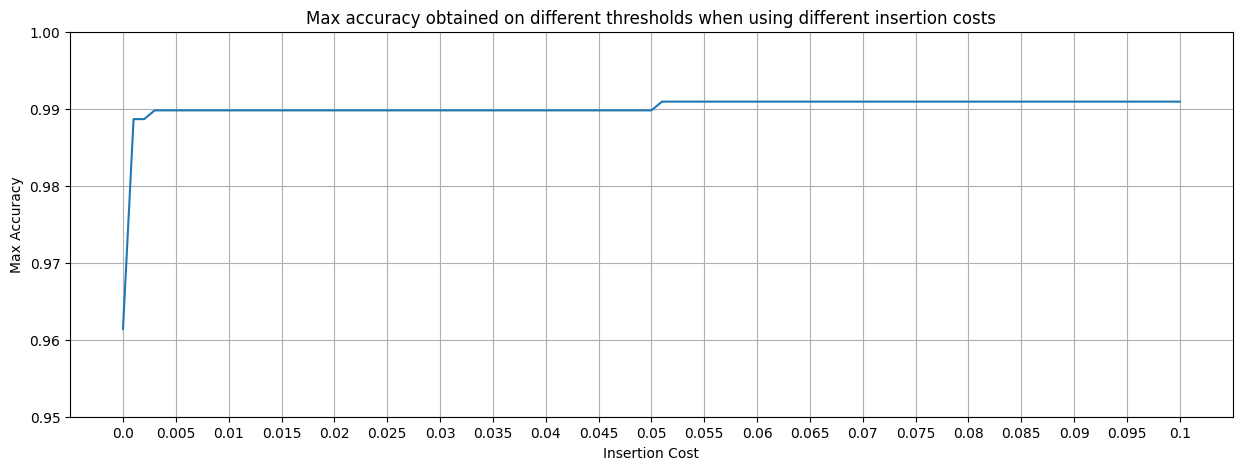

In [36]:
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(ins_cost_range, max_acc)
plt.xticks(np.arange(0, 10.5, 0.5)/10, np.arange(0, 10.5, 0.5)/100)
plt.xlabel('Insertion Cost')
plt.ylabel('Max Accuracy') 
plt.title('Max accuracy obtained on different thresholds when using different insertion costs')
plt.grid()   
plt.ylim([0.95, 1.0])  
plt.show()

## We can see that an insertion cost of 1 works just fine